In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import mixture

from geo_tool import Point_Cloud

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.point_clouds.convenience import reconstruct_pclouds, get_latent_codes

from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tf_lab.nips.helper import pclouds_centered_and_half_sphere
from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence

In [3]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [4]:
top_data_dir = '/orions4-zfs/projects/optas/DATA'
class_name = 'chair'
syn_id = snc_category_to_synth_id()[class_name]
n_pc_points = 2048
ae_experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
ae_loss = 'emd'
b_neck = 128
# cov_types = ['full', 'diag']
cov_types = ['full']
# diag_n_clusters = [5, 10, 20, 30, 128]
# full_n_clusters = range(2, 41, 2)
full_n_clusters = [32]

In [5]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_data = in_data['train'].point_clouds

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [6]:
top_lin_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
top_out_dir = osp.join(top_lin_dir, 'OUT/iclr/synthetic_samples/' + \
                       'gmm_' + ae_loss + '_' + class_name)
create_dir(top_out_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/synthetic_samples/gmm_emd_chair'

In [7]:
def load_an_auto_encoder(b_neck, at_experiment_tag, ae_loss, n_pc_points=2048):
    # Load Auto-Encoder    
    ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
    ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
    ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))    
    val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))        
    if best_epoch % ae_conf.saver_step != 0:
        best_epoch += best_epoch % ae_conf.saver_step
    ae_conf.encoder_args['verbose'] = False
    ae_conf.decoder_args['verbose'] = False
    reset_tf_graph()
    ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
    ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)
    return ae

In [8]:
ae_model = load_an_auto_encoder(b_neck, ae_experiment_tag, ae_loss)
latent_codes = get_latent_codes(ae_model, train_data)

for cov_t in cov_types:
    if cov_t == 'diag':
        choose_from = diag_n_clusters
    else: 
        choose_from = full_n_clusters

    for n_cluster in choose_from:
        gmm = mixture.GaussianMixture(n_cluster, cov_t)
        gmm.fit(latent_codes)
        sample_codes = gmm.sample(len(latent_codes))[0]
        gmm_pcs = ae_model.decode(sample_codes)
        tag = '_'.join(['bneck', str(b_neck), cov_t, str(n_cluster), 'gaussians'])
#         np.savez(osp.join(top_out_dir, tag), gmm_pcs)
        print cov_t, n_cluster, gmm.bic(latent_codes), gmm.aic(latent_codes)

Model restored in epoch 400.
full 32 -905739.98783 -2692440.34792


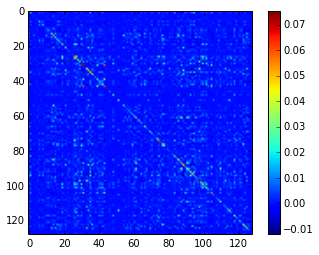

In [31]:
fig = plt.imshow(np.mean(gmm.covariances_, axis=0), cmap=plt.cm.jet)
plt.colorbar()
plt.savefig('average_covariance.pdf')
np.savez('average_covariance', np.mean(gmm.covariances_, axis=0))
('gmm_means', ae_model.decode(gmm.means_))